# **CommonLit Readability - EDA**

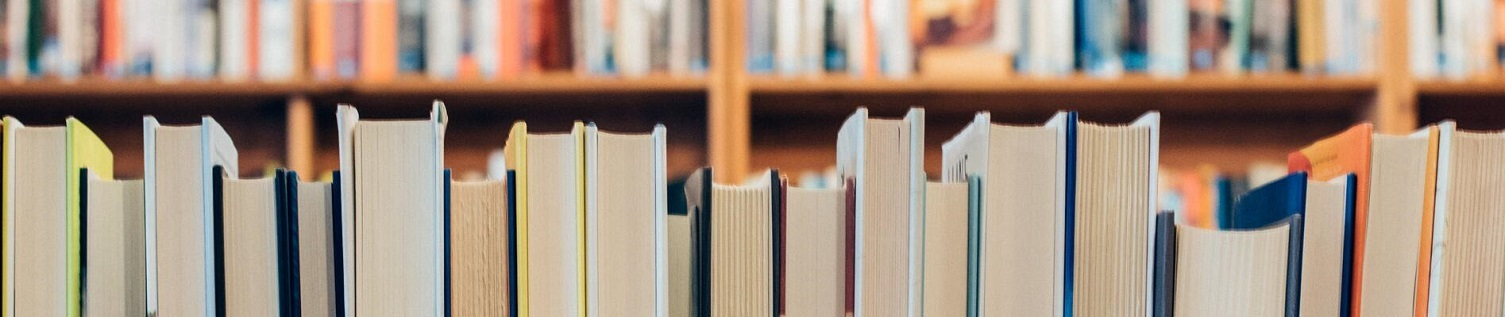

# Introduction 
* In this competition, we’ll build algorithms to rate the complexity of reading passages for grade 3-12 classroom use.
* This will aid administrators, teachers, and students. And literacy curriculum developers and teachers who choose passages will be able to quickly and accurately evaluate works for their classrooms

# Data

## Files
* **train.csv** - the training set
* **test.csv** - the test set
* **sample_submission.csv** - a sample submission file in the correct format

## Columns
* **id** - unique ID for excerpt
* **url_legal** - URL of source - this is blank in the test set.
* **license** - license of source material - this is blank in the test set.
* **excerpt** - text to predict reading ease of
* **target** - reading ease
* **standard_error** - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

# Import libraries

In [ ]:
!pip install textstat
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import nltk
import textstat
import time
import wandb

from pandas import DataFrame
from matplotlib.lines import Line2D
import plotly.express as px
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

from transformers import TFRobertaForSequenceClassification, RobertaTokenizerFast
nltk.download('stopwords')

# Load data


In [ ]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
test_filepath = '/kaggle/input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

print(f'Train samples: {len(train)}')
display(train.head())

print(f'Test samples: {len(test)}')
display(test.head())


# Let's take around Dataset

## The first 7 rows

In [ ]:
train.head()

## The 7 lowest target values

In [ ]:
train.sort_values(by=['target']).head(7)

## The 7 highest  target values

In [ ]:
train.sort_values(by=['target'], ascending=False).head(7)

## Distribution

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#003f5c","#374c80","#bc5090","#ff764a","#ffa600"]
palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)




In [ ]:
train.nunique()

In [ ]:
msno.bar(train,color=palette[4], sort="ascending", figsize=(10,5), fontsize=15)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.distplot(train['target'], ax=ax,color=palette[0])
plt.title("Target Distribution",font="Serif",size="18")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.distplot(train['standard_error'], ax=ax,color=palette[0])
plt.title("Standard_error Distribution",font="Serif",size="18")
plt.show()

In [ ]:
sns.jointplot(x=train['target'], y=train['standard_error'], kind='hex',height=8,color=palette[1])
plt.suptitle("Target vs Standard error ",font="Serif",size="18")
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y="license",data=train,linewidth=3,color=palette[4])
plt.title("License Distribution",font="Serif",size="18")
plt.show()

In [ ]:
BASE_MODEL = '/kaggle/input/huggingface-roberta/roberta-base/'
tokenizer = RobertaTokenizerFast.from_pretrained(BASE_MODEL)
train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_wordCnt'] = train['excerpt'].apply(lambda x : len(x.split(' ')))
train['excerpt_tokenCnt'] = train['excerpt'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
sns.distplot(train['excerpt_len'], ax=ax,color=palette[0]).set_title('Excerpts length',font="Serif",size="18")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_wordCnt'], ax=ax,color=palette[0]).set_title('Excerpts word count',font="Serif",size="18")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_tokenCnt'], ax=ax,color=palette[0]).set_title('Excerpt token count',font="Serif",size="18")
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation
from nltk.tokenize import word_tokenize

all_stopwords = stopwords.words('english')
#########################################
sw_list = ['know','\'re','n\'t','going','-','_','—','’','‘','us','say','said']
all_stopwords.extend(sw_list)
#########################################

def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

def remove_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)

sentences=train['excerpt'].tolist()
sentences="".join(sentences)

sentences=remove_stopwords(sentences)
sentences=remove_punctuation(sentences)

plt.rcParams['figure.figsize'] = (20,7)
wordcloud = WordCloud().generate(sentences)

wordcloud = WordCloud(width=1000,
                     height=600,
                      stopwords=STOPWORDS,
                      random_state=42,
                       background_color='white',
                       collocations=False).generate(sentences)
plt.imshow(wordcloud)
plt.axis("off")


## Unigrams & Bigrams & Trigrams

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_bt(x,w,p):
    common_words = x(train['excerpt_preprocessed'], 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,font='Serif')
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df

In [ ]:
def preprocess(data):
    excerpt_processed=[]
    for e in data['excerpt']:
        
        # find alphabets
        e = re.sub("[^a-zA-Z]", " ", e)
        
        # convert to lower case
        e = e.lower()
        
        # tokenize words
        e = nltk.word_tokenize(e)
        
        # remove stopwords
        e = [word for word in e if not word in set(stopwords.words("english"))]
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e=" ".join(e)
        
        excerpt_processed.append(e)
        
    return excerpt_processed

train["excerpt_preprocessed"] = preprocess(train)
test["excerpt_preprocessed"] = preprocess(test)

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [ ]:
def bar_plot(df,x,x_title,y,title,colors=None,text=None):
    fig = px.bar(x=x,
                 y=y,
                 text=text,
                 labels={x: x_title.title()},   
                 data_frame=df,
                 color=colors,
                 barmode='group',
                 template="simple_white")
    
    texts = [df[col].values for col in y]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'inside'
        
    fig['layout'].title=title

    fig.update_layout(title_font_size=19)
    fig.update_layout(title_font_family='Droid Serif')
        
  

    for trace in fig.data:
        trace.name = trace.name.replace('_',' ').title()

    fig.update_yaxes(tickprefix="", showgrid=True)

    fig.show()

In [ ]:
common_words = get_top_n_words(train['excerpt_preprocessed'], 20)
common_words_df1 = DataFrame(common_words,columns=['word','freq'])
bar_plot(common_words_df1.iloc[:20],
         'word',
         'Word',
         ['freq'],
         title='Top 20 unigrams')

In [ ]:
common_words = get_top_n_bigram(train['excerpt_preprocessed'], 20)
common_words_df2 = DataFrame(common_words,columns=['word','freq'])
bar_plot(common_words_df2.iloc[:20],
         'word',
         'Word',
         ['freq'],
         title='Top 20 bigrams')

In [ ]:
common_words = get_top_n_trigram(train['excerpt_preprocessed'], 20)
common_words_df3 = DataFrame(common_words,columns=['word','freq'])
bar_plot(common_words_df3.iloc[:20],
         'word',
         'Word',
         ['freq'],
         title='Top 20 trigrams')

* target <= 0 --> High Complexity
* target > 0 --> Low Complexity


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

text_len = train[train['target'] <= 0]['excerpt'].str.split().map(lambda x: len(x))
sns.distplot(text_len, ax=ax[0], color=palette[0])
ax[0].set_title('High Complexity')

text_len = train[train['target'] > 0]['excerpt'].str.split().map(lambda x: len(x))
sns.distplot(text_len, ax=ax[1],color=palette[4])
ax[1].set_title('Low Complexity')

fig.suptitle('Number of Words in text')
plt.show()

In [ ]:
def avg_word_len(text):
    avg_len = text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return avg_len

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

avg_len = avg_word_len(train[train['target'] <= 0]['excerpt'])
sns.distplot(avg_len, ax=ax[0], color=palette[0])
ax[0].set_title('High Complexity')

avg_len = avg_word_len(train[train['target'] > 0]['excerpt'])
sns.distplot(avg_len, ax=ax[1], color=palette[4])
ax[1].set_title('Low Complexity')

fig.suptitle('Average word length in a text')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

no_sents = train[train['target'] <= 0]['excerpt'].apply(lambda x : len(x.split('\n')))
sns.distplot(no_sents, ax=ax[0], color=palette[0])
ax[0].set_title('High Complexity')

no_sents = train[train['target'] > 0]['excerpt'].apply(lambda x : len(x.split('\n')))
sns.distplot(no_sents, ax=ax[1], color=palette[4])
ax[1].set_title('Low Complexity')

fig.suptitle('Number of Sentences in text')
plt.show()

In [ ]:
def clean_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[\.\,]', '', text)
    text = text.lower()
    return text

train['excerpt_clean'] = train['excerpt'].apply(clean_text)
easier_words = ' '.join(train[train['target'] > 0]['excerpt_clean'].values)
harder_words = ' '.join(train[train['target'] < 0]['excerpt_clean'].values)

easier_words_wordcloud = WordCloud(width=900,
                                   height=600,
                                   stopwords=STOPWORDS,
                                   random_state=42,
                                   background_color='white',
                                   collocations=False).generate(easier_words)
harder_words_wordcloud = WordCloud(width=900,
                                   height=600,
                                   stopwords=STOPWORDS,
                                   random_state=42,
                                   background_color='white',
                                   collocations=False).generate(harder_words)

fig, axes = plt.subplots(ncols=2, figsize=(32, 10))
axes[0].imshow(easier_words_wordcloud)
axes[1].imshow(harder_words_wordcloud)
for i in range(2):
    axes[i].tick_params(axis='x', labelsize=15, pad=10)
    axes[i].tick_params(axis='y', labelsize=15, pad=10)    
axes[0].set_title('Low Complexity Excerpts', pad=15,font="Serif",size="20")
axes[0].axis("off")
axes[1].set_title('High Complexity Excerpts',  pad=15,font="Serif",size="20")
axes[1].axis("off")

plt.show()

In [ ]:
text_props = train.copy()

def avg_word_len(df):
    df = df.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return df

text_len = train['excerpt'].str.len()
text_len_pre = train['excerpt_preprocessed'].str.len()
avg_text = avg_word_len(train['excerpt'])
avg_text_pre = avg_word_len(train['excerpt_preprocessed'])
lexicon_count = []
lexicon_count_pre = []
sentence_count = []
for i in range(len(train)):
    lc = textstat.lexicon_count(train['excerpt'][i])
    lcp = textstat.lexicon_count(train['excerpt_preprocessed'][i])
    sc = textstat.sentence_count(train['excerpt'][i])
    lexicon_count.append(lc)
    lexicon_count_pre.append(lcp)
    sentence_count.append(sc)
    
text_props['text_len'] = text_len
text_props['text_len_pre'] = text_len_pre
text_props['lexicon_count'] = lexicon_count
text_props['lexicon_count_pre'] = lexicon_count_pre
text_props['avg_text'] = avg_text
text_props['avg_text_pre'] = avg_text_pre
text_props['sentence_count'] = sentence_count

def plot_distribution(col1,col2,title1,title2):
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    sns.kdeplot(data=text_props, x=col1,color=palette[0],label="Excerpt",ax=ax[0])
    sns.kdeplot(data=text_props, x=col2,color=palette[4],label="Excerpt preprocessed",ax=ax[0])
    ax[0].set_title(title1,font="Serif")

    sns.scatterplot(data=text_props,x=col1,y='target',color= palette[0],ax=ax[1],markers='.')
    sns.scatterplot(data=text_props,x=col2,y='target',color= palette[4],ax=ax[1],markers='.')
    ax[1].set_title(title2,font="Serif")

    plt.show()

custom_lines = [Line2D([0], [0], color=palette[0], lw=4),
                Line2D([0], [0], color=palette[4], lw=4)]

plt.figure(figsize=(20, 1))
legend = plt.legend(custom_lines, ['Excerpt', 'Excerpt preprocessed'],loc="center")
plt.setp(legend.texts, family='Serif')
plt.axis('off')
plt.show()

plot_distribution("text_len","text_len_pre","Character count distribution","Character count vs Target")
plot_distribution("lexicon_count","lexicon_count_pre","Word count distribution","Word count vs Target")
plot_distribution("avg_text","avg_text_pre", "Average word length distribution","Average word length vs Target")

fig, ax = plt.subplots(1,2,figsize=(15,6))
sns.kdeplot(data=text_props, x=sentence_count,color=palette[0],label="Excerpt",ax=ax[0])
ax[0].set_title("Sentence count distribution",font="Serif")
ax[0].set_xlabel("sentence_count")
sns.scatterplot(data=text_props,x='sentence_count',y='target',color= palette[0],ax=ax[1],markers='.')
ax[1].set_title("Sentence count vs Target",font="Serif")
plt.show()

num_cols = ['text_len','text_len_pre','lexicon_count','lexicon_count_pre','avg_text','avg_text_pre','sentence_count','target']
corr = text_props[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='Oranges', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of text properties', fontsize=15,font="Serif")
plt.show()

# Part Of Speech (POS) Tagging
* The process of assigning a part-of-speech to each word in a sentence 

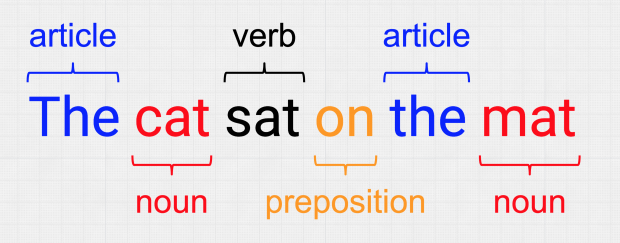

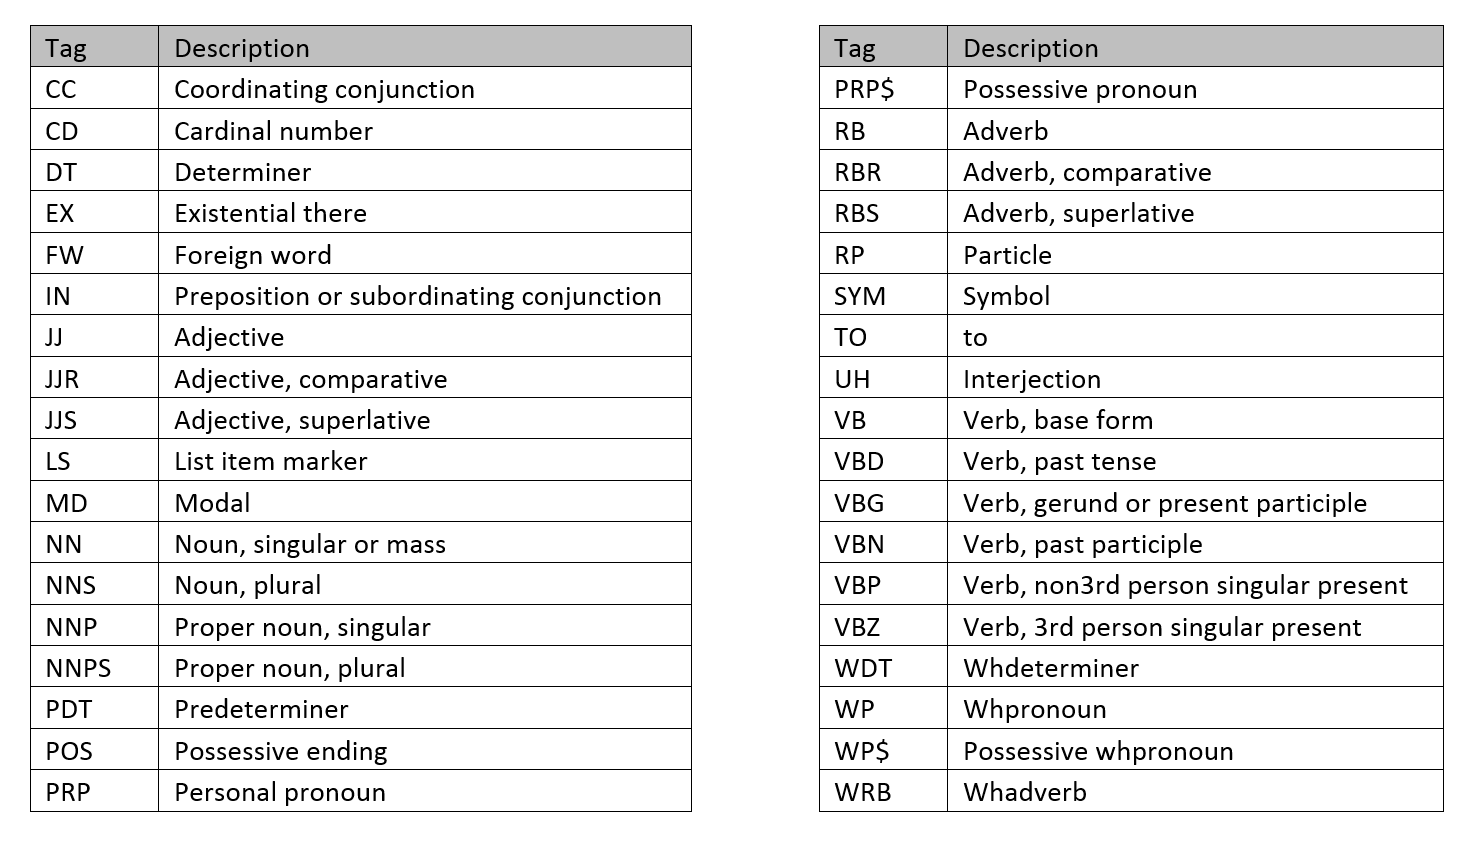


In [ ]:
text_props['pos_tags'] = train['excerpt_preprocessed'].str.split().map(pos_tag)

def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

text_props['tag_counts'] = text_props['pos_tags'].map(count_tags)

In [ ]:
set_pos = set([tag for tags in text_props['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tag_cols:
    text_props[tag] = text_props['tag_counts'].map(lambda x: x.get(tag, 0))

In [ ]:
pos = text_props[tag_cols].sum().sort_values(ascending = False)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=pos.index, y=pos.values,color=palette[1])
plt.xticks(rotation = 90)
ax.set_yscale('log')
plt.title('POS Tags Frequency',fontsize=15,font="Serif")
plt.show()

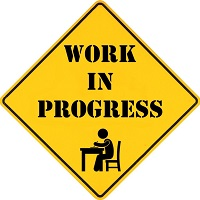

# References
* https://www.kaggle.com/dimitreoliveira/commonlit-readability-eda-roberta-tf-baseline
* https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-baseline
* https://www.kaggle.com/alaasedeeq/commonlit-readability-eda
* https://www.kaggle.com/utcarshagrawal/commonlit-eda-model-ml-dl
* https://www.kaggle.com/gunesevitan/commonlit-readability-prize-eda